In [16]:
from pathlib import Path
import numpy as np
import pydicom
import SimpleITK as sitk
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import zipfile
import os
import csv
import io
import numpy as np
import imageio
from tqdm import tqdm


print("pydicom", pydicom.__version__)
print("SimpleITK", sitk.Version_VersionString())
print("matplotlib", matplotlib.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)


def check_version(module_name, version_attr='__version__', call_func=None):
    """Безопасно импортирует модуль и выводит его версию."""
    try:
        module = __import__(module_name)
        if call_func:
            version = call_func(module)
        else:
            version = getattr(module, version_attr)
        print(f"{module_name:<12} {version}")
    except ImportError:
        print(f"{module_name:<12} NOT INSTALLED")
    except Exception as e:
        print(f"Could not get version for {module_name}: {e}")

print("--- Core Application Libraries ---")
check_version("streamlit")
check_version("pydicom")
check_version("numpy")
check_version("pandas")
check_version("PIL", "VERSION") # Для Pillow

print("\n--- Data Preparation & Analysis Libraries ---")
check_version("imageio")
check_version("tqdm")
check_version("matplotlib")
check_version("SimpleITK", call_func=lambda sitk: sitk.Version_VersionString())

pydicom 3.0.1
SimpleITK 2.5.2
matplotlib 3.9.2
numpy 2.1.2
pandas 2.2.2
--- Core Application Libraries ---
streamlit    1.49.1
pydicom      3.0.1
numpy        2.1.2
pandas       2.2.2
Could not get version for PIL: module 'PIL' has no attribute 'VERSION'

--- Data Preparation & Analysis Libraries ---
imageio      2.36.0
tqdm         4.66.5
matplotlib   3.9.2
SimpleITK    2.5.2


In [2]:
# ==============================================================================
# Утилиты, не требующие изменений
# ==============================================================================

def get_meta(ds):
    """Извлекает метаданные из DICOM-файла. Остается без изменений."""
    return {
        "Modality": getattr(ds, "Modality", None),
        "StudyUID": getattr(ds, "StudyInstanceUID", None),
        "SeriesUID": getattr(ds, "SeriesInstanceUID", None),
        "NumberOfFrames": getattr(ds, "NumberOfFrames", None),
        "PixelSpacing": getattr(ds, "PixelSpacing", None),
        "SliceThickness": getattr(ds, "SliceThickness", None),
        "Slope": getattr(ds, "RescaleSlope", 1.0),
        "Intercept": getattr(ds, "RescaleIntercept", 0.0),
        "Shape": (ds.pixel_array.shape if "PixelData" in ds else None),
    }

def to_uint8(x):
    """Конвертирует нормализованный массив (0-1) в 8-битное изображение (0-255)."""
    x = np.clip(x, 0, 1)
    return (x * 255).astype(np.uint8)


# ==============================================================================
# Адаптированные функции нормализации (теперь работают со всеми срезами)
# ==============================================================================

def norm_ct(ds, center=-600, width=1500):
    """
    Нормализует КТ-изображение.
    Теперь применяет оконное преобразование ко всем срезам в 3D-массиве.
    """
    arr = ds.pixel_array.astype(np.float32)
    arr = arr * float(getattr(ds, "RescaleSlope", 1.0)) + float(getattr(ds, "RescaleIntercept", 0.0))
    
    lo, hi = center - width / 2, center + width / 2
    arr = (np.clip(arr, lo, hi) - lo) / (hi - lo)
    return arr

def norm_crdx(ds):
    """
    Нормализует рентген (CR/DX).
    Теперь нормализует каждый срез индивидуально по его перцентилям.
    """
    arr = ds.pixel_array.astype(np.float32)
    # Если это 3D-массив (серия кадров), обрабатываем каждый кадр отдельно
    if arr.ndim == 3:
        for i in range(arr.shape[0]):
            slc = arr[i]
            lo, hi = np.percentile(slc, 0.5), np.percentile(slc, 99.5)
            arr[i] = (np.clip(slc, lo, hi) - lo) / (hi - lo + 1e-6)
    else: # Если изображение одно (2D), обрабатываем как раньше
        lo, hi = np.percentile(arr, 0.5), np.percentile(arr, 99.5)
        arr = (np.clip(arr, lo, hi) - lo) / (hi - lo + 1e-6)
    return arr

def norm_mr(ds):
    """
    Нормализует МРТ.
    Теперь нормализует каждый срез индивидуально.
    """
    arr = ds.pixel_array.astype(np.float32)
    if arr.ndim == 3:
        for i in range(arr.shape[0]):
            slc = arr[i]
            mu, sigma = np.median(slc), np.std(slc)
            slc = (slc - mu) / (sigma + 1e-6)
            lo, hi = np.percentile(slc, 0.5), np.percentile(slc, 99.5)
            arr[i] = (np.clip(slc, lo, hi) - lo) / (hi - lo + 1e-6)
    else:
        mu, sigma = np.median(arr), np.std(arr)
        arr = (arr - mu) / (sigma + 1e-6)
        lo, hi = np.percentile(arr, 0.5), np.percentile(arr, 99.5)
        arr = (np.clip(arr, lo, hi) - lo) / (hi - lo + 1e-6)
    return arr

def norm_us(ds):
    """
    Нормализует УЗИ.
    Теперь нормализует каждый срез индивидуально.
    """
    arr = ds.pixel_array.astype(np.float32)
    if arr.ndim == 3:
        for i in range(arr.shape[0]):
            slc = arr[i]
            lo, hi = np.percentile(slc, 1), np.percentile(slc, 99)
            arr[i] = (np.clip(slc, lo, hi) - lo) / (hi - lo + 1e-6)
    else:
        lo, hi = np.percentile(arr, 1), np.percentile(arr, 99)
        arr = (np.clip(arr, lo, hi) - lo) / (hi - lo + 1e-6)
    return arr


# ==============================================================================
# Главная функция-диспетчер (теперь возвращает все срезы)
# ==============================================================================

def normalize_dicom_and_get_frames(ds):
    """
    Определяет тип исследования и вызывает соответствующий нормализатор.
    Гарантированно возвращает 3D-массив (коллекцию) обработанных срезов.
    """
    mod = getattr(ds, "Modality", "").upper()
    
    if mod == "CT":
        processed_array = norm_ct(ds)
    elif mod in ("CR", "DX"):
        processed_array = norm_crdx(ds)
    elif mod == "MR":
        processed_array = norm_mr(ds)
    elif mod in ("US", "Ultrasound"):
        processed_array = norm_us(ds)
    else:
        # Дефолтная min-max нормализация, если тип не определен
        processed_array = ds.pixel_array.astype(np.float32)
        lo, hi = processed_array.min(), processed_array.max()
        processed_array = (processed_array - lo) / (hi - lo + 1e-6)

    # Убеждаемся, что на выходе всегда 3D-массив для единообразной обработки
    if processed_array.ndim == 2:
        processed_array = np.expand_dims(processed_array, axis=0)
        
    return processed_array

---

# Data Extracting

In [3]:
MAIN_ZIP_PATH = 'Датасет.zip'
BASE_DIR = 'data'
RAW_DIR = os.path.join(BASE_DIR, 'raw')
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
CSV_PATH = 'data_info.csv'

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

In [4]:
csv_data = []

print(f"\nНачинаю обработку архива '{MAIN_ZIP_PATH}'...")
try:
    with zipfile.ZipFile(MAIN_ZIP_PATH, 'r') as main_zip:
        class_archives = [name for name in main_zip.namelist() if name.endswith('.zip')]
        
        # === 1. Определяем заголовки для CSV заранее ===
        # Это более надежный подход
        fieldnames = [
            'image_path', 'raw_path', 'class', 'modality', 
            'pixel_spacing', 'slice_thickness', 'num_frames_total', 'slice_index'
        ]
        
        for nested_zip_path in tqdm(class_archives, desc="Обработка классов"):
            class_name = os.path.basename(nested_zip_path).replace('.zip', '')
            
            with zipfile.ZipFile(io.BytesIO(main_zip.read(nested_zip_path))) as nested_zip:
                for dcm_info in nested_zip.infolist():
                    if dcm_info.is_dir(): continue
                    
                    dcm_filename = os.path.basename(dcm_info.filename)
                    if not dcm_filename: continue

                    # Сохраняем сырой DICOM
                    raw_filepath = os.path.join(RAW_DIR, dcm_filename)
                    with open(raw_filepath, 'wb') as f:
                        f.write(nested_zip.read(dcm_info.filename))

                    # Обрабатываем DICOM и извлекаем метаданные
                    try:
                        ds = pydicom.dcmread(raw_filepath)
                        
                        # === 2. Извлекаем полезные метаданные ОДИН раз для файла ===
                        modality = getattr(ds, "Modality", "N/A")
                        # PixelSpacing - это объект, приводим к строке для CSV
                        pixel_spacing = str(getattr(ds, "PixelSpacing", "N/A")) 
                        slice_thickness = str(getattr(ds, "SliceThickness", "N/A"))
                        
                        normalized_frames = normalize_dicom_and_get_frames(ds)
                        num_frames_total = len(normalized_frames)
                        
                        base_name = dcm_filename.rsplit('.', 1)[0]

                        # Проходим по каждому срезу
                        for i, frame_2d in enumerate(normalized_frames):
                            uint8_image = to_uint8(frame_2d)
                            png_filename = f"{base_name}_frame_{i:03d}.png"
                            image_filepath = os.path.join(IMAGES_DIR, png_filename)
                            imageio.imwrite(image_filepath, uint8_image)
                            
                            # === 3. Добавляем в CSV всю собранную информацию ===
                            csv_data.append({
                                'image_path': image_filepath.replace('\\', '/'),
                                'raw_path': raw_filepath.replace('\\', '/'),
                                'class': class_name,
                                'modality': modality,
                                'pixel_spacing': pixel_spacing,
                                'slice_thickness': slice_thickness,
                                'num_frames_total': num_frames_total,
                                'slice_index': i # Порядковый номер текущего среза
                            })
                    except Exception as e:
                        print(f"\n[ПРЕДУПРЕЖДЕНИЕ] Не удалось обработать файл {dcm_filename}: {e}")

except FileNotFoundError:
    print(f"[ОШИБКА] Архив '{MAIN_ZIP_PATH}' не найден.")
    exit()

# === 4. Записываем CSV, используя определенные ранее заголовки ===
if csv_data:
    print(f"\nЗапись {len(csv_data)} строк в файл '{CSV_PATH}'...")
    with open(CSV_PATH, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(csv_data)
    print("Готово! Процесс успешно завершен.")
else:
    print("\n[ПРЕДУПРЕЖДЕНИЕ] Не было обработано ни одного файла.")


Начинаю обработку архива 'Датасет.zip'...


Обработка классов: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.37s/it]


Запись 1294 строк в файл 'data_info.csv'...
Готово! Процесс успешно завершен.


In [5]:
df = pd.read_csv('data_info.csv')
print(df['class'].value_counts())
df.head(3)

class
pneumotorax_anon    476
norma_anon          451
pneumonia_anon      367
Name: count, dtype: int64


,image_path,raw_path,class,modality,pixel_spacing,slice_thickness,num_frames_total,slice_index
0,data/images/10000E6B_anon_frame_000.png,data/raw/10000E6B_anon,norma_anon,CT,"[0.782, 0.782]",1.0,1,0
1,data/images/10000E6C_anon_frame_000.png,data/raw/10000E6C_anon,norma_anon,CT,"[0.782, 0.782]",1.0,1,0
2,data/images/10000E6D_anon_frame_000.png,data/raw/10000E6D_anon,norma_anon,CT,"[0.782, 0.782]",1.0,1,0


In [7]:
df['raw_path'].value_counts().head()

raw_path
data/raw/10000CF6_anon    476
data/raw/10000381_anon      1
data/raw/10000382_anon      1
data/raw/10000383_anon      1
data/raw/10000384_anon      1
Name: count, dtype: int64

# EDA

In [10]:
path = "data/raw/10000CF6_anon"
ds = pydicom.dcmread(path)
meta = get_meta(ds)
meta

{'Modality': 'CT',
 'StudyUID': '1.2.276.0.7230010.3.1.2.2462171185.19116.1754560222.2501',
 'SeriesUID': '1.2.276.0.7230010.3.1.3.2462171185.19116.1754560222.2502',
 'NumberOfFrames': '476',
 'PixelSpacing': None,
 'SliceThickness': None,
 'Slope': 1.0,
 'Intercept': 0.0,
 'Shape': (476, 512, 512)}

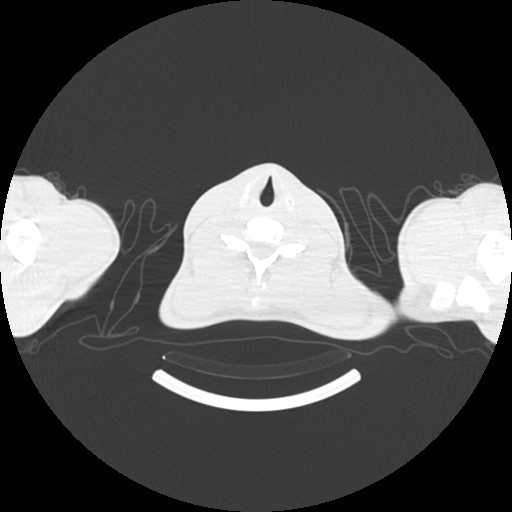

In [11]:
all_frames = normalize_dicom_and_get_frames(ds)
one_frame_to_show = all_frames[0]
Image.fromarray(to_uint8(one_frame_to_show))